<a href="https://colab.research.google.com/github/BelideSaiTeja/Traffic-Sign-Recognition-System/blob/main/Traffic_Signs_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Traffic Sign Recognition Deep Learning Project**


In this project, Deep Learning techniques are used to build a robust traffic sign recognition system. We explore the use of Convolutional Neural Networks (CNNs), which have proven to be highly effective in image classification tasks. The model is trained on a large dataset of annotated traffic sign images, allowing it to learn the distinctive features of different signs.

**WORKFLOW**

The below 4 steps to build traffic sign classification model:

* Dataset exploration

* CNN model building

* Model training and validation

* Model testing

# **IMPORTING DATASET**

The dataset used for this project is the [GTSRB (German Traffic Sign Recognition Benchmark)](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign), which consists of thousands of labeled images across 43 different classes of traffic signs. The dataset is divided into a training set and a testing set, enabling us to train our model on one subset and evaluate its performance on another.

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:31<00:00, 20.9MB/s]
100% 612M/612M [00:31<00:00, 20.1MB/s]


In [ ]:
! unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

# **DATASET EXPLORATION**

Around 43 subfolders(ranging from 0 to 42) are available in our 'Train' folder, and each subfolder represents a different class. Iterating all the images with their respective classes and labels.



In [ ]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2

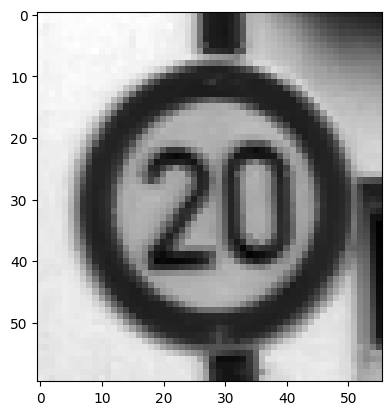

In [ ]:
DATADIR = '/content/Train'
Categories = [str(i) for i in range(42)]

for category in Categories:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_arr, cmap = 'gray')
    plt.show()
    break
  break

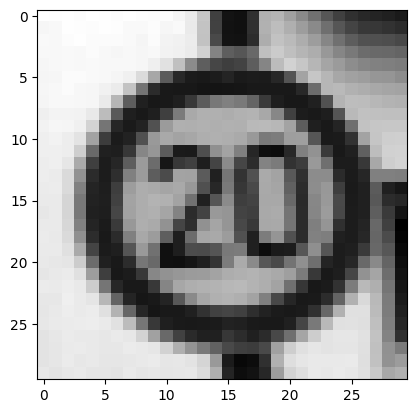

In [ ]:
# resizing image
IMG_SIZE = 30

new_array = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [ ]:
# Creating Dataset to train model

training_data = []

def create_training_data():
  for category in Categories:
    path = os.path.join(DATADIR, category)
    class_num = Categories.index(category)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass

create_training_data()

In [ ]:
random.shuffle(training_data)

In [ ]:
# Separating features and targets (labels)

data = []
labels = []

for features, label in training_data:
  data.append(features)
  labels.append(label)

data = np.array(data).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
labels = np.array(labels)

In [ ]:
data.shape

(38969, 30, 30, 1)

In [ ]:
labels.shape

(38969,)

From training Dataset, taking out validation data of size 0.2 times of training data from training data.

In [ ]:
# splitting into train and test data
from sklearn.model_selection import train_test_split
data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size = 0.2, random_state = 52)

In [ ]:
data_train.shape, data_val.shape, labels_train.shape, labels_val.shape

((31175, 30, 30, 1), (7794, 30, 30, 1), (31175,), (7794,))

In [ ]:
data_train = data_train/255.0
data_val = data_val/255.0

# **CNN MODEL DEVELOPMENT**

Using keras tuner model is built.

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-20-2bbfbe7dae29>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


Using 2 Convolution layers, 1 Flatten layer, 1 Dense layer and 1 Output layer model is being developed along with hyperparameter tuning to recognize the number of neurons in each layer.

In [ ]:
# model development

def build_model(hp):
  model = keras.Sequential([
      keras.layers.Conv2D(
          filters = hp.Int('conv_1_filter', min_value = 16, max_value = 128, step = 8),
          kernel_size = hp.Choice('conv_1_kernel', values = [3, 6]),
          activation = 'relu',
          input_shape = (30, 30, 1)
      ),
      keras.layers.Conv2D(
          filters = hp.Int('conv_2_filter', min_value = 32, max_value = 256, step = 16),
          kernel_size = hp.Choice('conv_2_kernel', values = [3, 6]),
          activation = 'relu'
      ),
      keras.layers.Flatten(),
      keras.layers.Dense(
          units = hp.Int('dense_1_units', min_value = 16, max_value = 256, step = 16),
          activation = 'relu'
      ),
      keras.layers.Dense(43, activation = 'softmax')
  ])

  model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3])),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_search = RandomSearch(build_model,
                            objective = 'val_accuracy',
                            max_trials = 10,
                            directory = 'Output',
                            project_name = 'Traffic Sign Recognition')

# **MODEL VALIDATION**

In [ ]:
tuner_search.search(data_train, labels_train, epochs = 3, validation_data = (data_val, labels_val))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
88                |88                |conv_1_filter
6                 |6                 |conv_1_kernel
240               |240               |conv_2_filter
6                 |6                 |conv_2_kernel
32                |32                |dense_1_units
0.01              |0.01              |learning_rate

Epoch 1/3
975/975 [==============================] - 1295s 1s/step - loss: 3.6224 - accuracy: 0.0569 - val_loss: 3.4692 - val_accuracy: 0.0547
Epoch 2/3
975/975 [==============================] - 1204s 1s/step - loss: 3.4765 - accuracy: 0.0557 - val_loss: 3.4688 - val_accuracy: 0.0582
Epoch 3/3
971/975 [============================>.] - ETA: 4s - loss: 3.4754 - accuracy: 0.0565

In [ ]:
best_model = tuner_search.get_best_models(num_models = 1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 104)       3848      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 160)       149920    
                                                                 
 flatten (Flatten)           (None, 84640)             0         
                                                                 
 dense (Dense)               (None, 144)               12188304  
                                                                 
 dense_1 (Dense)             (None, 43)                6235      
                                                                 
Total params: 12,348,307
Trainable params: 12,348,307
Non-trainable params: 0
_________________________________________________________________


In [ ]:
final_model = best_model.fit(data_train, labels_train, epochs = 50, validation_data = (data_val, labels_val))

Epoch 1/50
975/975 [==============================] - 11s 10ms/step - loss: 0.0365 - accuracy: 0.9890 - val_loss: 0.1192 - val_accuracy: 0.9714
Epoch 2/50
975/975 [==============================] - 10s 10ms/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 0.0884 - val_accuracy: 0.9761
Epoch 3/50
975/975 [==============================] - 10s 10ms/step - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0938 - val_accuracy: 0.9796
Epoch 4/50
975/975 [==============================] - 9s 9ms/step - loss: 0.0217 - accuracy: 0.9933 - val_loss: 0.0697 - val_accuracy: 0.9895
Epoch 5/50
975/975 [==============================] - 9s 10ms/step - loss: 0.0171 - accuracy: 0.9952 - val_loss: 0.1257 - val_accuracy: 0.9769
Epoch 6/50
975/975 [==============================] - 12s 13ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 0.0867 - val_accuracy: 0.9824
Epoch 7/50
975/975 [==============================] - 10s 10ms/step - loss: 0.0158 - accuracy: 0.9955 - val_loss: 0.0691 - val_accuracy: 0.

In [ ]:
best_model.evaluate(data_train, labels_train)
print("Training Accuracy: ", best_model.evaluate(data_train, labels_train)[1])

975/975 [==============================] - 4s 4ms/step - loss: 0.0070 - accuracy: 0.9988
Training Accuracy:  0.9988131523132324


In [ ]:
best_model.evaluate(data_val, labels_val)
print("Validation Accuracy: ", best_model.evaluate(data_val, labels_val)[1])

244/244 [==============================] - 1s 4ms/step - loss: 0.2072 - accuracy: 0.9886
Validation Accuracy:  0.9885809421539307


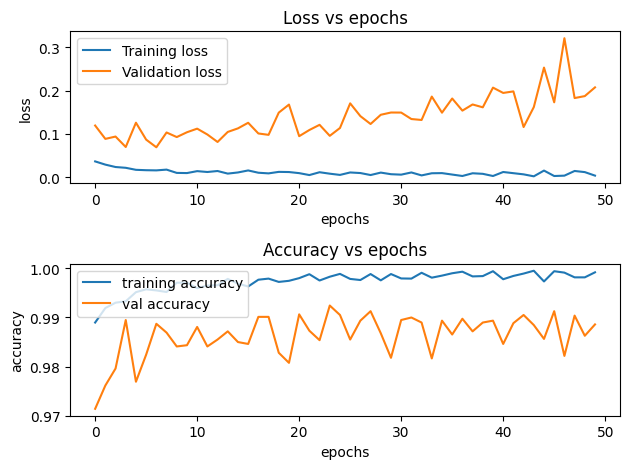

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(final_model.history['loss'], label='Training loss')
plt.plot(final_model.history['val_loss'], label='Validation loss')
plt.title('Loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper left')

plt.subplot(2, 1, 2)
plt.plot(final_model.history['accuracy'], label='training accuracy')
plt.plot(final_model.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc = 'upper left')
plt.tight_layout()

# **MODEL TESTING ON TEST DATA**

In [ ]:
from PIL import Image
import cv2
y_test = pd.read_csv('/content/Test.csv')
values = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]
for img in imgs:
   image = Image.open(img)
   image = image.resize((30,30))
   image = image.convert('L')
   data.append(np.array(image))
data_test=np.array(data)

In [ ]:
eval_result = best_model.evaluate(data_test, values)
print("Test Accuracy: ", eval_result[1])

395/395 [==============================] - 2s 4ms/step - loss: 609.2796 - accuracy: 0.9081
Test Accuracy:  0.9080759882926941


In [ ]:
best_model.save('traffic_classifier.h5')

In [ ]:
pred = np.argmax(best_model.predict(data_test), axis = 1)

395/395 [==============================] - 1s 3ms/step


# **PREDICTIVE MODELLING SYSTEM**

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

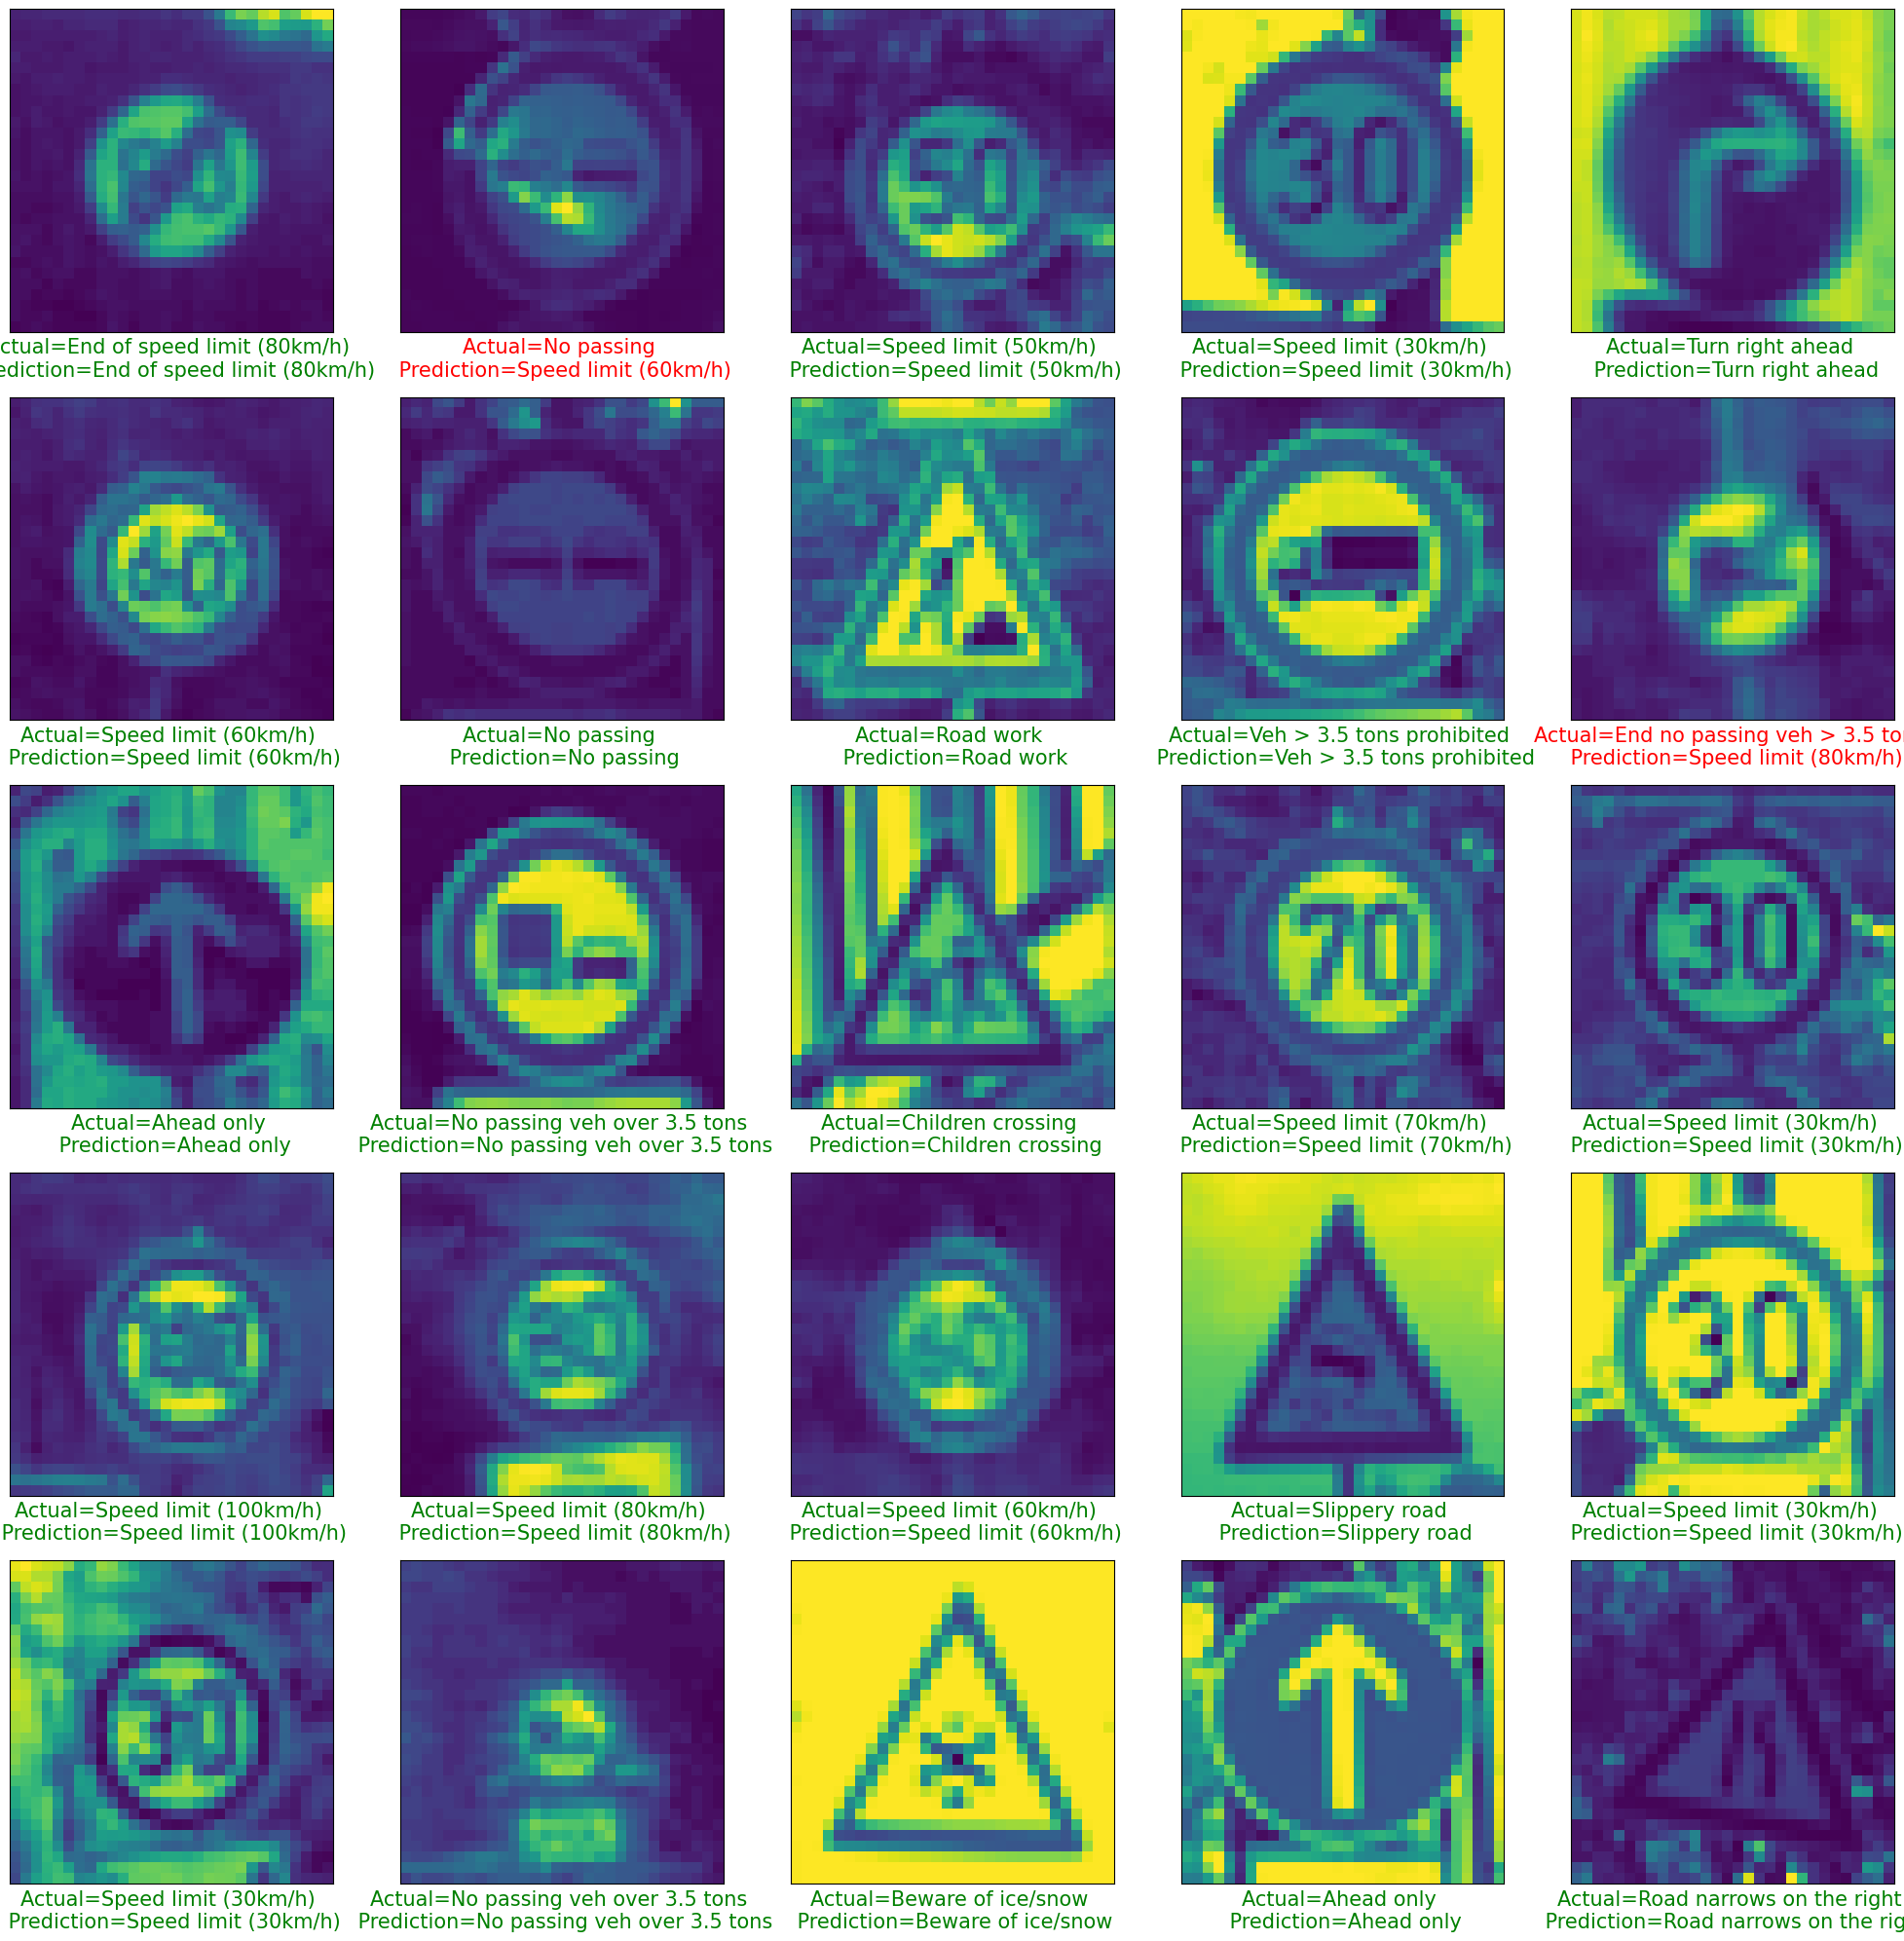

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 861
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = values[start_index + i]
    col = 'g'
    if prediction != actual:
      col = 'r'
    plt.xlabel('Actual={} \n Prediction={}'.format(classes.get(actual), classes.get(prediction)), color = col, fontsize = 15)
    plt.imshow(data_test[start_index + i])
plt.show()

# **SUMMARY**

In this project, Traffic Sign Classification and Recognition with Keras and Deep Learning is performed.

In this project,


*   Utilized the popular German Traffic Sign Recognition Benchmark (GTSRB) as  dataset.
*   Implemented a Convolutional Neural Network (CNN) using the Keras deep learning library.
*   Trained Convolutional Neural Network (CNN) on the GTSRB dataset, obtaining 91% accuracy on test data.
*   Created a Python script that loads our trained model and then classifies new input images.



# **Future Enhancements**

While our current model performs well, there are several avenues for improvement:

**Data Augmentation:** Implement additional data augmentation techniques to increase model robustness.

**Model Ensembling:** Combine multiple models to improve overall performance.

**Real-world Testing:** Evaluate the model on real-world images and video streams.